In [1]:
#import dependencies

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
from conv_vae import ConvVAE
from data_utils import read_dataset
import time
from scipy.stats import norm

W1002 16:11:13.744895 4476605888 deprecation.py:323] From /anaconda2/envs/brain/lib/python3.6/site-packages/tensorflow_core/python/compat/v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# read data set
train_ds, valid_ds = read_dataset('data/frames', test_size = 0.097)
print(train_ds.images().shape)
print((train_ds.images().nbytes + valid_ds.images().nbytes) / (1024.0 * 1024.0), 'MB')

(2497, 64, 64, 3)
129.65625 MB


In [3]:
latent_dim = 10
batch_size = 50

# let's create ConvVAE
cvae = ConvVAE(latent_dim, batch_size)

W1002 16:11:31.361009 4476605888 deprecation.py:323] From /anaconda2/envs/brain/lib/python3.6/site-packages/tensorflow_core/python/ops/math_grad.py:1423: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
# let's train ConvVAE
num_epochs = 15
interval = 200

saver = tf.train.Saver(max_to_keep = 2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    t = time.time()
    # for num of epochs    
    while(train_ds.epochs_completed() < num_epochs):
        
        current_epoch = train_ds.epochs_completed()
        step = 0
        print('[----Epoch {} is started ----]'.format(current_epoch))
        
        # take next batch until epoch is completed        
        while(train_ds.epochs_completed() < current_epoch + 1):
            input_images = train_ds.next_batch(batch_size)
            # do training step
            cvae.training_step(sess, input_images)
            step += 1
            
            if step % interval == 0:
                print('loss: {} validation loss: {}'.format(cvae.loss_step(sess, input_images),\
                                                            cvae.loss_step(sess, valid_ds.next_batch(batch_size))))
                
        print('[----Epoch {} is finished----]'.format(current_epoch))
        saver.save(sess, 'checkpoints/', global_step=current_epoch)
        print('[----Checkpoint is saved----]')
     
    print('Training time: {}s'.format(time.time() - t))
    
    # let's see how well our model reconstructs input images       
    input_images = train_ds.next_batch(batch_size)

    output_images = cvae.recognition_step(sess, input_images)
    output_images = output_images * 255
    output_images = output_images.astype(np.uint8)
    print('Shape= ', output_images.shape)

[----Epoch 0 is started ----]
[----Epoch 0 is finished----]
[----Checkpoint is saved----]
[----Epoch 1 is started ----]
[----Epoch 1 is finished----]
[----Checkpoint is saved----]
[----Epoch 2 is started ----]


W1002 16:11:50.634191 4476605888 deprecation.py:323] From /anaconda2/envs/brain/lib/python3.6/site-packages/tensorflow_core/python/training/saver.py:963: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[----Epoch 2 is finished----]
[----Checkpoint is saved----]
[----Epoch 3 is started ----]
[----Epoch 3 is finished----]
[----Checkpoint is saved----]
[----Epoch 4 is started ----]
[----Epoch 4 is finished----]
[----Checkpoint is saved----]
[----Epoch 5 is started ----]
[----Epoch 5 is finished----]
[----Checkpoint is saved----]
[----Epoch 6 is started ----]
[----Epoch 6 is finished----]
[----Checkpoint is saved----]
[----Epoch 7 is started ----]
[----Epoch 7 is finished----]
[----Checkpoint is saved----]
[----Epoch 8 is started ----]
[----Epoch 8 is finished----]
[----Checkpoint is saved----]
[----Epoch 9 is started ----]
[----Epoch 9 is finished----]
[----Checkpoint is saved----]
[----Epoch 10 is started ----]
[----Epoch 10 is finished----]
[----Checkpoint is saved----]
[----Epoch 11 is started ----]
[----Epoch 11 is finished----]
[----Checkpoint is saved----]
[----Epoch 12 is started ----]
[----Epoch 12 is finished----]
[----Checkpoint is saved----]
[----Epoch 13 is started ----]
[--

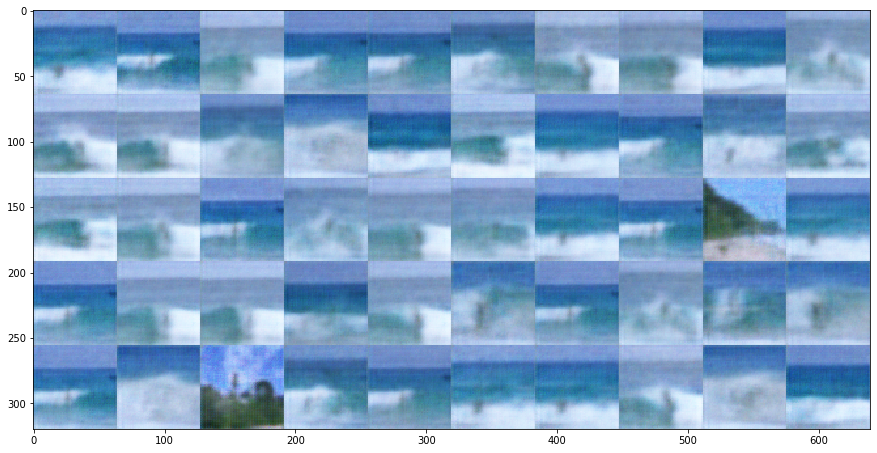

In [5]:
# Let's plot them!!!

w = 10
h = 5
figure = np.zeros([64 * h, 64 * w, 3], dtype = np.uint8)
k = 0
for i in range(h):
    for j in range(w):
        image = np.reshape(output_images[k], [64, 64, 3])
        figure[i * 64: (i + 1) * 64,
               j * 64: (j + 1) * 64,
               :] = image
        k += 1
    
plt.figure(figsize=(15, 15))
plt.imshow(figure)
plt.show()

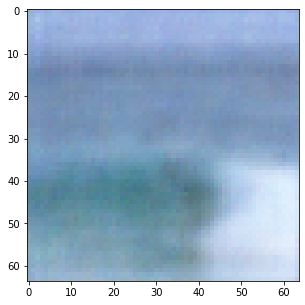

In [6]:
# Let's see another one
plt.figure(figsize = (5, 5))
plt.imshow(np.reshape(output_images[7], [64, 64, 3]))
plt.show()

z= [ 0.67448974 -0.38532048 -1.64485359  0.67448974 -1.03643334 -0.12566137
  1.64485347  0.3853204   1.03643346  0.12566137]
Shape= (1, 64, 64, 3)


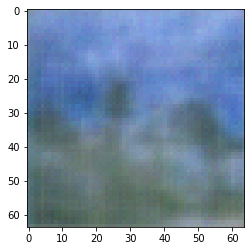

In [7]:
# reset computational graph
tf.reset_default_graph()

# create model
cvae = ConvVAE(latent_dim, batch_size = 1)

# restoration
saver = tf.train.Saver()
path = tf.train.latest_checkpoint('checkpoints')

with tf.Session() as sess:
    # restore session    
    saver.restore(sess, path)
    
    # let's create random latent vector from normal distribution     
    # z = np.random.normal(size = latent_dim)
    
    vals = np.array([np.linspace(0.05, 0.95, latent_dim, dtype = np.float32) for i in range(latent_dim)])
    vals = np.reshape(vals, [latent_dim * latent_dim])
    z_samples = norm.ppf(vals)
    z_samples = np.random.permutation(z_samples)
            
    print('z=',z_samples[:latent_dim])
    
    # Generate a new video frame
    output_image = cvae.generation_step(sess, np.reshape(z_samples[:latent_dim], [1, latent_dim]))
    output_image = output_image * 255
    output_image = output_image.astype(np.uint8)
    
    print('Shape=',output_image.shape)
    
    # plot it
    plt.imshow(np.reshape(output_image, [64, 64, 3]))
    plt.show()